# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Manipulation des données

Dans cette partie, je modifie le dataset d'airbnb que j'ai récupéré pour avoir que les données qui me serviront dans le machine learning et que je trouve pertinente.

Pour cela je vais :
1. sélectionner les colonnes pertinentes
2. remplacer les colonnes cleaning_fee et instant_bookable par des 1 et des 0
3. supprimer les appartements qui n'ont pas de reviews (je considère qu'ils n'ont pas été loués)
4. récupérer le prix en $ (actuellement en logarithme)
5. Remplacer les choix contenu dans les colonnes city et cancellation_policy par plusieurs colonnes en 1 et 0
6. Transformer les dates en timestamp pour pouvoir les manipuler


PS : Je voudrais calculer des catégories de prix mais cela ne me semble pas possible avec les données réelles car pour New-York le prix moyen est de 396€ ce qui me semble beaucoup trop élevé pour le dataset que je possède. L'on peut voir un échantillon des prix pour cette ville dans le dernier print avant le `df.head()`.
Donc je fais un calcule avec les données que je possède dans la partie suivante

In [71]:
df = pd.read_csv('data/airbnb_data.csv')

df = df[['log_price', 'room_type', 'accommodates', 'cancellation_policy', 'cleaning_fee', 'city', 'first_review', 'instant_bookable', 'number_of_reviews', 'review_scores_rating', 'bedrooms']]
df['cleaning_fee'] = df['cleaning_fee'].astype(int)
df['instant_bookable'] = df['instant_bookable'].apply(lambda x: 1 if x == 'f' else 0)
df = df.dropna(axis=0, subset=['first_review'])
df['price_by_night'] = np.exp(df['log_price'])
df = df.drop(labels='log_price', axis=1)
df['price_by_person'] = df['price_by_night'] / df['accommodates']

unique_cities = df['city'].unique()
print(unique_cities) # ['NYC' 'DC' 'SF' 'LA' 'Chicago' 'Boston']
df_cities = pd.get_dummies(df['city'], prefix='city', dtype=int)
df = pd.concat([df, df_cities], axis=1)

unique_policies = df['cancellation_policy'].unique()
print(unique_policies) # ['strict' 'moderate' 'flexible' 'super_strict_30' 'super_strict_60']
# df = pd.get_dummies(df, columns=['cancellation_policy'], dtype=int)

unique_room_type = df['room_type'].unique()
print(unique_room_type) # ['Entire home/apt' 'Private room' 'Shared room']

print(df['cleaning_fee'].value_counts())

df['first_review'] = pd.to_datetime(df['first_review'])
df['first_review_timestamp'] = df['first_review'].apply(lambda x: x.timestamp())

df_ny = df[(df['city_NYC'] == 1)]
print(df_ny['price_by_night'])

df.head()

['NYC' 'DC' 'SF' 'LA' 'Chicago' 'Boston']
['strict' 'moderate' 'flexible' 'super_strict_30' 'super_strict_60']
['Entire home/apt' 'Private room' 'Shared room']
cleaning_fee
1    46063
0    12184
Name: count, dtype: int64
0        150.0
1        169.0
2        145.0
10       100.0
18       132.0
         ...  
74094     40.0
74096     50.0
74097    110.0
74100    100.0
74108    185.0
Name: price_by_night, Length: 25491, dtype: float64


,room_type,accommodates,cancellation_policy,cleaning_fee,city,first_review,instant_bookable,number_of_reviews,review_scores_rating,bedrooms,price_by_night,price_by_person,city_Boston,city_Chicago,city_DC,city_LA,city_NYC,city_SF,first_review_timestamp
0,Entire home/apt,3,strict,1,NYC,2016-06-18,1,2,100.0,1.0,150.0,50.000000,0,0,0,0,1,0,1.466208e+09
1,Entire home/apt,7,strict,1,NYC,2017-08-05,0,6,93.0,3.0,169.0,24.142857,0,0,0,0,1,0,1.501891e+09
2,Entire home/apt,5,moderate,1,NYC,2017-04-30,0,10,92.0,1.0,145.0,29.000000,0,0,0,0,1,0,1.493510e+09
4,Entire home/apt,2,moderate,1,DC,2015-05-12,0,4,40.0,0.0,115.0,57.500000,0,0,1,0,0,0,1.431389e+09
5,Private room,2,strict,1,SF,2017-08-27,0,3,100.0,1.0,85.0,42.500000,0,0,0,0,0,1,1.503792e+09


# Numpy, Pandas & Matplop

## Calcule de la catégorie de prix pour chaque ville

Je vais appliquer le principe suivant (dans une boucle pour itérer sur chaque ville) :
1. Je récupère le prix et nombre de personnes acceptées pour chaque appartement
2. Je divise le prix par le nombre de personne (pour avoir le prix par personne)
3. Je calcule la moyenne de prix par personne

Une fois ma moyenne par ville calculée, j'itère pour chaque entrée de mon dataset (via `df.apply()`) :
1. Je calcule le prix par personne
2. je récupère la moyenne en fonction de la ville de l'appartement
3. J'applique des pourcentages au prix pour savoir dans quelle catégorie je le classe

Après cela, je calcule la moyenne de la note par catégorie, et je génère un graphique graphique de la répartition des appartements par catégorie avec la moyenne des notes.

/var/folders/b3/tn1zt4lx1j1_0hhxtfhfgwp80000gn/T/ipykernel_1857/1614699014.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_city['price_per_person'] = df_city['price_by_night'] / df_city['accommodates']
/var/folders/b3/tn1zt4lx1j1_0hhxtfhfgwp80000gn/T/ipykernel_1857/1614699014.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_city['price_per_person'] = df_city['price_by_night'] / df_city['accommodates']
/var/folders/b3/tn1zt4lx1j1_0hhxtfhfgwp80000gn/T/ipykernel_1857/1614699014.py:6: SettingWithCo

{'NYC': 51.78700216792043, 'DC': 47.06039207376285, 'SF': 69.38497806451686, 'LA': 44.17583710691291, 'Chicago': 35.77842045010958, 'Boston': 53.500549767817944}


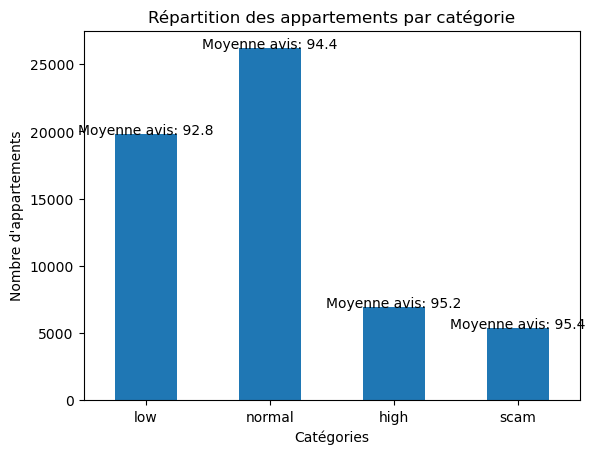

In [72]:
CITIES = unique_cities
averages = {}

for city in CITIES:
  df_city = df[df['city'] == city]
  df_city['price_per_person'] = df_city['price_by_night'] / df_city['accommodates']
  average = df_city['price_per_person'].mean()
  averages[city] = average

print(averages)

def categorize_price(row):
  price = row['price_by_night'] / row['accommodates']
  average = averages[row['city']]

  if price < average * 0.7:
    return 'low'
  elif price < average * 1.3:
    return 'normal'
  elif price < average * 1.7:
    return 'high'
  else:
    return 'scam'
  
df['category'] = df.apply(categorize_price, axis=1)
rating_category_average = df.groupby('category')['review_scores_rating'].mean()
category_order = ['low', 'normal', 'high', 'scam']
category_counts = df['category'].value_counts().reindex(category_order)

plt.figure()
ax = category_counts.plot(kind='bar')
plt.title('Répartition des appartements par catégorie')
plt.xlabel('Catégories')
plt.ylabel("Nombre d'appartements")
plt.xticks(rotation=0)

for i, (category, count) in enumerate(category_counts.items()):
    mean_rating = rating_category_average[category]
    ax.text(i, count + 0.5, f'Moyenne avis: {mean_rating:.1f}', ha='center', fontsize=10, color='black')

plt.show()

## Manipulation de l'année de premier commentaire

Je calcule la répartition appartements par année pour générer un graphique en bar. Je rajoute pour chaque année le prix moyen par nuit par personne et je le visualise via ue courbe verte sur le même graphique.

Date minimale :  2008-11-17 00:00:00
Date maximale :  2017-10-05 00:00:00
Moyenne de la date :  2016-01-14 08:11:51.013442755
year
2008    36.000000
2009    48.879659
2010    52.603781
2011    54.622992
2012    56.160267
2013    56.377777
2014    53.412859
2015    51.646340
2016    47.718754
2017    48.305290
Name: price_by_person, dtype: float64


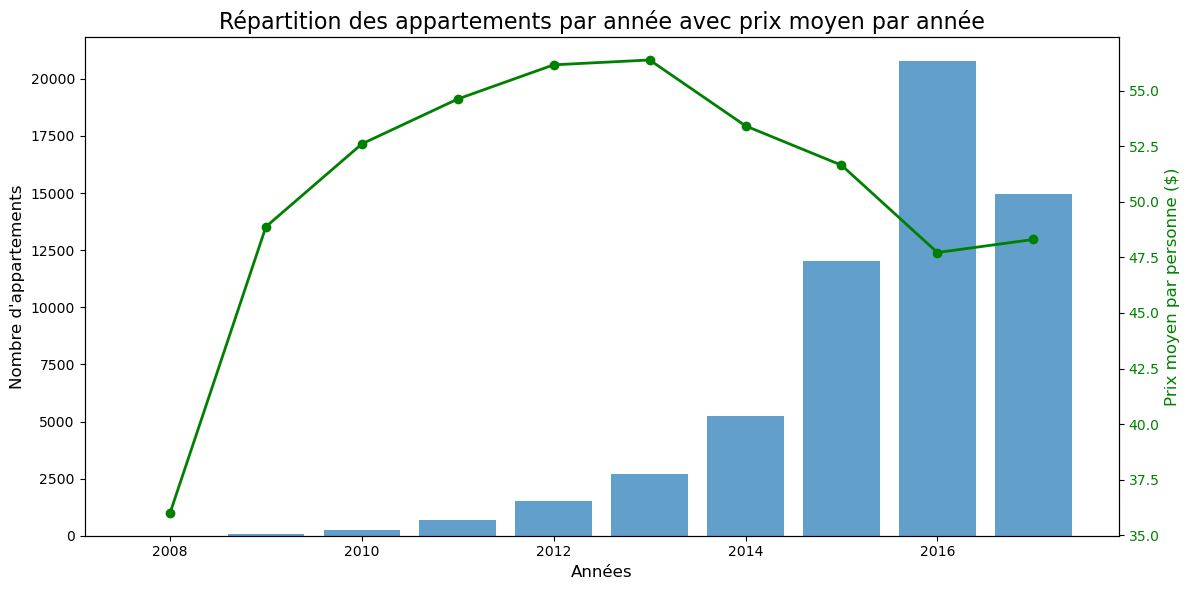

In [70]:
min_timestamp = df['first_review_timestamp'].min()
min_date = pd.to_datetime(min_timestamp, unit='s')

max_timestamp = df['first_review_timestamp'].max()
max_date = pd.to_datetime(max_timestamp, unit='s')

average_timestamp = df['first_review_timestamp'].mean()
average_date = pd.to_datetime(average_timestamp, unit='s')

print("Date minimale : ", min_date)
print("Date maximale : ", max_date)
print("Moyenne de la date : ", average_date)

df['year'] = df['first_review'].dt.year
year_counts = df['year'].value_counts().sort_index()
year_price_average = df.groupby('year')['price_by_person'].mean().sort_index()
print(year_price_average)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot
bars = ax1.bar(year_counts.index, year_counts.values, width=0.8, alpha=0.7)
ax1.set_xlabel('Années', fontsize=12)
ax1.set_ylabel("Nombre d'appartements", fontsize=12)
ax1.set_title('Répartition des appartements par année avec prix moyen par année', fontsize=16)
ax1.tick_params(axis='y')
plt.xticks(rotation=0)

# Line plot
ax2 = ax1.twinx()
line = ax2.plot(year_price_average.index, year_price_average.values, color='green', marker='o', linestyle='-', linewidth=2, markersize=6)
ax2.set_ylabel('Prix moyen par personne ($)', fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Adjust layout and display
plt.tight_layout()
plt.show()

## Manipulation des colonnes frais de ménage et réservation immédiate

In [30]:
cleaning_fee_proportion = df['cleaning_fee'].mean()
instant_bookable_proportion = df['instant_bookable'].mean()

print(f"Moyenne d'appartements possédant des frais de ménage : {np.round(cleaning_fee_proportion * 100, 2)} %")
print(f"Moyenne d'appartements qui permet une réservation immédiate : {np.round(instant_bookable_proportion * 100)} %")

Moyenne d'appartements possédant des frais de ménage : 79.08 %
Moyenne d'appartements qui permet une réservation immédiate : 73.0 %


## Nombres de personnes acceptées

Moyenne de personnes par appartement :  3.2118220680893437
Médiane de personnes par appartement :  2.0
Variance de personnes par appartement :  4.589474630428239
Écart-type de personnes par appartement :  2.1423059142961445


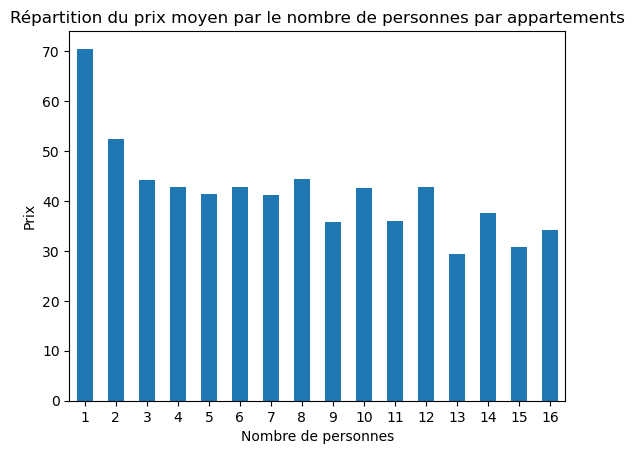

In [77]:
accommodates_average = df['accommodates'].mean()
accommodates_median = df['accommodates'].median()
accommodates_variance = df['accommodates'].var()
accommodates_deviation = df['accommodates'].std()

print("Moyenne de personnes par appartement : ", accommodates_average)
print("Médiane de personnes par appartement : ", accommodates_median)
print("Variance de personnes par appartement : ", accommodates_variance)
print("Écart-type de personnes par appartement : ", accommodates_deviation)

accommodates_price_average = df.groupby('accommodates')['price_by_person'].mean()

plt.figure()
ax = accommodates_price_average.plot(kind='bar')
plt.title('Répartition du prix moyen par le nombre de personnes par appartements')
plt.xlabel('Nombre de personnes')
plt.ylabel("Prix ($)")
plt.xticks(rotation=0)
plt.show()